In [87]:
import pandas as pd
import numpy as np
from math import radians, atan, tan, sin, acos, cos
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
import sklearn.cross_validation
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
train = pd.read_csv('D:/bmsz/train_new.csv', low_memory=False)
test = pd.read_csv('D:/bmsz/test_new.csv', low_memory=False)

In [114]:
def getDistance(latA, lonA, latB, lonB):  
    ra = 6378140  # radius of equator: meter  
    rb = 6356755  # radius of polar: meter  
    flatten = (ra - rb) / ra  # Partial rate of the earth  
    # change angle to radians  
    radLatA = radians(latA)  
    radLonA = radians(lonA)  
    radLatB = radians(latB)  
    radLonB = radians(lonB)  
  
    try: 
        pA = atan(rb / ra * tan(radLatA))  
        pB = atan(rb / ra * tan(radLatB))  
        x = acos(sin(pA) * sin(pB) + cos(pA) * cos(pB) * cos(radLonA - radLonB))  
        c1 = (sin(x) - x) * (sin(pA) + sin(pB))**2 / cos(x / 2)**2  
        c2 = (sin(x) + x) * (sin(pA) - sin(pB))**2 / sin(x / 2)**2  
        dr = flatten / 8 * (c1 - c2)  
        distance = ra * (x + dr)  
        return distance  # meter   
    except:
        return 0.0000001
def score(latA, lonA, latB, lonB): #计算分数
    res = 0
    for i in range(len(latA)):
        d = getDistance(latA[i], lonA[i], latB[i], lonB[i])
        res += 1. / (1. + np.exp(-(d-1000)/250.))
    return res / len(latA)

In [4]:
# #############################################################################
trL = train.shape[0] * 2
X = np.concatenate([train[['start_lat', 'start_lon']].values,
                    train[['end_lat', 'end_lon']].values,
                    test[['start_lat', 'start_lon']].values])
X.shape

(3049725, 2)

In [5]:
# Compute DBSCAN
db = DBSCAN(eps=5e-4, min_samples=3, p=1, leaf_size=10, n_jobs=-1).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('Estimated number of clusters: %d' % n_clusters_)

Estimated number of clusters: 110226


In [6]:
# train info
info = pd.DataFrame(X[:trL,:], columns=['lat', 'lon'])
info['block_id'] = labels[:trL]
clear_info = info.loc[info.block_id != -1, :]
print('The number of miss start block in train data', (info.block_id.iloc[:trL//2] == -1).sum())
print('The number of miss end block in train data', (info.block_id.iloc[trL//2:] == -1).sum())
# test info
test_info = pd.DataFrame(X[trL:,:], columns=['lat', 'lon'])
test_info['block_id'] = labels[trL:]
print('The number of miss start block in test data', (test_info.block_id == -1).sum())

The number of miss start block in train data 271285
The number of miss end block in train data 274566
The number of miss start block in test data 11519


In [7]:
train['start_block'] = info.block_id.iloc[:trL//2].values
train['end_block'] = info.block_id.iloc[trL//2:].values
test['start_block'] = test_info.block_id.values
good_train_idx = (train.start_block != -1) & (train.end_block != -1)
print('The number of good training data', good_train_idx.sum())
good_train = train.loc[good_train_idx, :]
print('saving new train & test data')
good_train.to_csv('D:/bmsz/good_train.csv', index=None)
test.to_csv('D:/bmsz/good_test.csv', index=None)

The number of good training data 1033722
saving new train & test data


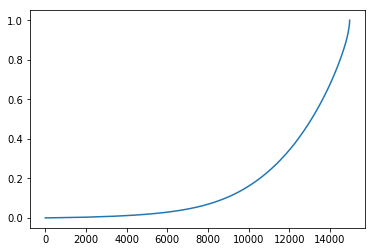

In [22]:
import matplotlib.pyplot as plt
tmp = good_train.loc[good_train.start_block.isin(test.start_block.values), :].start_block.value_counts(ascending=True).cumsum().values
tmp = tmp / tmp.max()
plt.plot(tmp)
plt.show()

In [8]:
tmp = good_train.loc[good_train.start_block.isin(test.start_block.values), :]
tmp.shape

(637540, 10)

#### 读取数据集

In [88]:
good_train = pd.read_csv('D:/bmsz/good_train.csv', low_memory=False)
good_test = pd.read_csv('D:/bmsz/good_test.csv', low_memory=False)
''' 划分验证集
good_y_train = good_train['end_block']
good_x_train = good_train.drop('end_block', axis=1)

good_x_train, good_x_test, good_y_train, good_y_test = train_test_split(good_x_train, good_y_train, test_size=0.1,random_state=0)

labels = good_x_test[['r_key', 'end_lat', 'end_lon']]
good_x_train['end_block'] = good_y_train
good_test = good_x_test.drop(['end_lat', 'end_lon'], axis=1)
'''

In [18]:
good_test.head()

,r_key,out_id,start_time,end_time,start_lat,start_lon,start_block,end_block
1000000,SDK-XJ_fc3d86e1f630fe5f57d4f8b83410ba32,891711711018191,2018-05-23 19:15:09,2018-05-23 19:37:24,26.251479,105.953981,93915,24614
1000001,SDK-XJ_f5606f33fcebdec334db7f274b341f96,891711711018191,2018-05-24 00:15:27,2018-05-24 00:25:52,26.225671,105.955097,104000,24569
1000002,SDK-XJ_6de8a8e487c9dcf4be46cecaec40e44b,891711711018191,2018-05-24 08:20:27,2018-05-24 08:54:52,26.255227,105.959929,12107,109658
1000003,SDK-XJ_1223c1125769af6aa7e432e267d20bf0,891711711018191,2018-05-25 08:07:52,2018-05-25 08:42:38,26.255277,105.959863,12107,109658
1000004,SDK-XJ_d0ac4aff960f940c22e7a10cc4ef734c,891711711018191,2018-05-26 09:33:32,2018-05-26 10:03:00,26.368222,105.943073,93925,24569


In [89]:
def transformer(df):
    special_holiday = ['2018-01-01'] + ['2018-02-%d' % d for d in range(15, 22)] + \
                      ['2018-04-%2d' % d for d in range(5, 8)] + \
                      ['2018-04-%d' % d for d in range(29, 31)] + ['2018-05-01'] +\
                      ['2018-06-%d' % d for d in range(16, 19)] + \
                      ['2018-09-%d' % d for d in range(22, 25)] + \
                      ['2018-10-%2d' % d for d in range(1, 8)]
    special_workday = ['2018-02-%d' % d for d in [11, 24]] + \
                      ['2018-04-08'] + ['2018-04-28'] + \
                      ['2018-09-%d' % d for d in range(29, 31)]
    for t_col in ['start_time']:
        tmp = df[t_col].map(pd.Timestamp)
        df['hour'] = tmp.map(lambda t: t.hour)
        df['half'] = tmp.map(lambda t: t.minute // 30)
        df['day'] = tmp.map(lambda t: t.dayofweek)
        tmp_date = df[t_col].map(lambda s: s.split(' ')[0])
        not_spworkday_idx = ~tmp_date.isin(special_workday)
        spholiday_idx = tmp_date.isin(special_holiday)
        weekend_idx = (df['day'] >= 5)
        df['is_holiday'] = ((weekend_idx & not_spworkday_idx) | spholiday_idx).astype(int)

transformer(good_train)
transformer(good_test)
good_train.head()

,r_key,out_id,start_time,end_time,start_lat,start_lon,end_lat,end_lon,start_block,end_block,hour,half,day,is_holiday
0,SDK-XJ_4c2f29d94c9478623711756e4ae34cc5,2016061820000b,2018-02-12 17:40:51,2018-02-12 17:58:13,34.810763,115.549264,34.814875,115.549374,0,95840,17,1,0,0
1,SDK-XJ_78d749a376e190685716a51a6704010b,2016061820000b,2018-02-13 17:23:08,2018-02-13 17:39:02,34.818280,115.542039,34.813141,115.559217,1,2,17,0,1,0
2,SDK-XJ_3b249941c27834f5e43d43a9114e4909,2016061820000b,2018-02-13 18:06:02,2018-02-13 19:02:51,34.813278,115.559260,34.786126,115.874361,2,3,18,0,1,0
3,SDK-XJ_9fd451509b05ecc54e641878a13baea8,2016061820000b,2018-02-13 20:58:36,2018-02-13 21:58:38,34.785990,115.874259,34.813162,115.559195,3,2,20,1,1,0
4,SDK-XJ_ca29f7fd306c47a407e4ab5aed21e7fb,2016061820000b,2018-02-14 08:54:02,2018-02-14 09:22:47,34.812824,115.559272,34.641016,115.536066,2,9,8,1,2,0


In [90]:
Probability = {}
## P(start_block|end_block)
name = 'start_block'
pname = 'P(start_block|end_block)'
print('calculating %s' % pname)
tmp_func = lambda g: (1.0 * g[name].value_counts()) / (len(g) + 10)
tmp = good_train.groupby('end_block').apply(tmp_func).reset_index()
tmp.columns = ['end_block', name, pname]
print(tmp.head())
Probability[pname] = tmp
## P(out_id|end_block)
name = 'out_id'
pname = 'P(out_id|end_block)'
print('calculating %s' % pname)
tmp_func = lambda g: (1.0 * g[name].value_counts()) / (len(g) + 10)
tmp = good_train.groupby('end_block').apply(tmp_func).reset_index()
tmp.columns = ['end_block', name, pname]
Probability[pname] = tmp
## P(is_holiday|end_block)
name = 'is_holiday'
pname = 'P(is_holiday|end_block)'
print('calculating %s' % pname)
tmp_func = lambda g: (1.0 * g[name].value_counts() + 3.) / (len(g) + 10)
tmp = good_train.groupby('end_block').apply(tmp_func).reset_index()
tmp.columns = ['end_block', name, pname]
Probability[pname] = tmp
## P((is_holiday, hour)|end_block)
pname = 'P((is_holiday, hour)|end_block)'
print('calculating %s' % pname)
tmp_func = lambda g: (5 + 1.0 * g.groupby(['is_holiday', 'hour']).size()) / (len(g))
tmp = good_train.groupby('end_block').apply(tmp_func).reset_index().rename(columns={0: pname})
print(tmp.head())
Probability[pname] = tmp
## P(day|end_block)
name = 'day'
pname = 'P(day|end_block)'
print('calculating %s' % pname)
tmp_func = lambda g: 1.0 * g[name].value_counts() / len(g)
tmp = good_train.groupby('end_block').apply(tmp_func).reset_index()
tmp.columns = ['end_block', name, pname]
Probability[pname] = tmp
## P(hour|end_block)
name = 'hour'
pname = 'P(hour|end_block)'
print('calculating %s' % pname)
tmp_func = lambda g: 1.0 * g[name].value_counts() / len(g)
tmp = good_train.groupby('end_block').apply(tmp_func).reset_index()
tmp.columns = ['end_block', name, pname]
Probability[pname] = tmp
## P((hour,half)|end_block)
pname = 'P((hour,half)|end_block)'
print('calculating %s' % pname)
tmp_func = lambda g: 1.0 * g.groupby(['hour', 'half']).size() / len(g)
tmp = good_train.groupby('end_block').apply(tmp_func).reset_index().rename(columns={0: pname})
Probability[pname] = tmp

calculating P(start_block|end_block)
   end_block  start_block  P(start_block|end_block)
0          0            0                  0.634146
1          0            9                  0.073171
2          0        10617                  0.048780
3          2            9                  0.275862
4          2            3                  0.103448
calculating P(out_id|end_block)
calculating P(is_holiday|end_block)
calculating P((is_holiday, hour)|end_block)
   end_block  is_holiday  hour  P((is_holiday, hour)|end_block)
0          0           0     8                         0.193548
1          0           0    10                         0.258065
2          0           0    11                         0.225806
3          0           0    12                         0.225806
4          0           0    13                         0.225806
calculating P(day|end_block)
calculating P(hour|end_block)
calculating P((hour,half)|end_block)


In [91]:
pname = 'P(end_block)'
print('calculating %s' % pname)
tmp = good_train.end_block.value_counts().reset_index()
tmp.columns = ['end_block', pname]
Probability[pname] = tmp

calculating P(end_block)


In [92]:
## P(end_block) * P(start_block|end_block) * P(out_id|end_block) * P(is_holiday|end_block)
is_local = False
if is_local:
    predict_info = good_train.copy()
    predict_info = predict_info.rename(columns={'end_block': 'true_end_block', 'end_lat': 'true_end_lat', 'end_lon': 'true_end_lon'})
else:
    predict_info = good_test.copy()

In [94]:
predict_info = predict_info.merge(Probability['P(out_id|end_block)'], on='out_id', how='left')
print(predict_info['P(out_id|end_block)'].isnull().sum())
predict_info['P(out_id|end_block)'] = predict_info['P(out_id|end_block)'].fillna(1e-5)
predict_info = predict_info.merge(Probability['P(is_holiday|end_block)'], on=['is_holiday', 'end_block'], how='left')
print(predict_info['P(is_holiday|end_block)'].isnull().sum())
predict_info['P(is_holiday|end_block)'] = predict_info['P(is_holiday|end_block)'].fillna(1e-4)
predict_info = predict_info.merge(Probability['P((is_holiday, hour)|end_block)'], on=['is_holiday', 'hour', 'end_block'], how='left')
print(predict_info['P((is_holiday, hour)|end_block)'].isnull().sum())
predict_info['P((is_holiday, hour)|end_block)'] = predict_info['P((is_holiday, hour)|end_block)'].fillna(1e-4)
predict_info = predict_info.merge(Probability['P(start_block|end_block)'], on=['start_block', 'end_block'], how='left')
print(predict_info['P(start_block|end_block)'].isnull().sum())
predict_info['P(start_block|end_block)'] = predict_info['P(start_block|end_block)'].fillna(1e-5)
predict_info = predict_info.merge(Probability['P(end_block)'], on='end_block', how='left')
print(predict_info['P(end_block)'].isnull().sum())
predict_info['P(end_block)'] = predict_info['P(end_block)'].fillna(1e-1)

0
417017
2066344
1712469
0


In [95]:
predict_info['P(end_block|(start_block, out_id, is_holiday))'] = predict_info['P(is_holiday|end_block)'] * \
                                                    predict_info['P(out_id|end_block)'] * \
                                                    predict_info['P(start_block|end_block)'] * \
                                                    predict_info['P(end_block)']
predict_info['P(end_block|(start_block, out_id, is_holiday, hour))'] = predict_info['P((is_holiday, hour)|end_block)'] * \
                                                    predict_info['P(out_id|end_block)'] * \
                                                    predict_info['P(start_block|end_block)'] * \
                                                    predict_info['P(end_block)']

In [96]:
predict_info

,r_key,out_id,start_time,end_time,start_lat,start_lon,start_block,hour,half,day,is_holiday,end_block,P(out_id|end_block),P(is_holiday|end_block),"P((is_holiday, hour)|end_block)",P(start_block|end_block),P(end_block),"P(end_block|(start_block, out_id, is_holiday))","P(end_block|(start_block, out_id, is_holiday, hour))"
0,SDK-XJ_5aa9b436c84dda4fd6b7b6e427136c4c,865821710040075,2018-06-28 17:00:15,2018-06-28 17:38:48,29.612307,106.496653,68430,17,0,3,0,3133,0.011111,0.711111,0.000100,0.000010,80,6.320988e-06,8.888889e-10
1,SDK-XJ_5aa9b436c84dda4fd6b7b6e427136c4c,865821710040075,2018-06-28 17:00:15,2018-06-28 17:38:48,29.612307,106.496653,68430,17,0,3,0,12883,0.451613,0.419355,0.000100,0.096774,21,3.848813e-01,9.177940e-05
2,SDK-XJ_5aa9b436c84dda4fd6b7b6e427136c4c,865821710040075,2018-06-28 17:00:15,2018-06-28 17:38:48,29.612307,106.496653,68430,17,0,3,0,12885,0.050000,0.600000,0.000100,0.000010,10,3.000000e-06,5.000000e-10
3,SDK-XJ_5aa9b436c84dda4fd6b7b6e427136c4c,865821710040075,2018-06-28 17:00:15,2018-06-28 17:38:48,29.612307,106.496653,68430,17,0,3,0,12897,0.153846,0.307692,0.000100,0.000010,3,1.420118e-06,4.615385e-10
4,SDK-XJ_5aa9b436c84dda4fd6b7b6e427136c4c,865821710040075,2018-06-28 17:00:15,2018-06-28 17:38:48,29.612307,106.496653,68430,17,0,3,0,12898,0.062500,0.500000,0.000100,0.062500,6,1.171875e-02,2.343750e-06
5,SDK-XJ_5aa9b436c84dda4fd6b7b6e427136c4c,865821710040075,2018-06-28 17:00:15,2018-06-28 17:38:48,29.612307,106.496653,68430,17,0,3,0,12962,0.166667,0.000100,0.000100,0.000010,2,3.333333e-10,3.333333e-10
6,SDK-XJ_5aa9b436c84dda4fd6b7b6e427136c4c,865821710040075,2018-06-28 17:00:15,2018-06-28 17:38:48,29.612307,106.496653,68430,17,0,3,0,35747,0.052632,0.578947,0.666667,0.052632,9,1.443359e-02,1.662050e-02
7,SDK-XJ_5aa9b436c84dda4fd6b7b6e427136c4c,865821710040075,2018-06-28 17:00:15,2018-06-28 17:38:48,29.612307,106.496653,68430,17,0,3,0,35826,0.071429,0.357143,0.000100,0.071429,4,7.288630e-03,2.040816e-06
8,SDK-XJ_5aa9b436c84dda4fd6b7b6e427136c4c,865821710040075,2018-06-28 17:00:15,2018-06-28 17:38:48,29.612307,106.496653,68430,17,0,3,0,65453,0.002049,0.866803,0.023013,0.002049,478,1.739838e-03,4.619054e-05
9,SDK-XJ_5aa9b436c84dda4fd6b7b6e427136c4c,865821710040075,2018-06-28 17:00:15,2018-06-28 17:38:48,29.612307,106.496653,68430,17,0,3,0,65668,0.891304,0.630435,0.317073,0.467391,82,2.153578e+01,1.083129e+01


In [97]:
predict_result = predict_info.groupby('r_key').apply(lambda g: g.loc[g['P(end_block|(start_block, out_id, is_holiday, hour))'].idxmax(), :]).reset_index(drop=True)
predict_result

,r_key,out_id,start_time,end_time,start_lat,start_lon,start_block,hour,half,day,is_holiday,end_block,P(out_id|end_block),P(is_holiday|end_block),"P((is_holiday, hour)|end_block)",P(start_block|end_block),P(end_block),"P(end_block|(start_block, out_id, is_holiday))","P(end_block|(start_block, out_id, is_holiday, hour))"
0,000764d77423d6a0_SDK-XJ_edca7f8b96b40636ccf1e8...,891641610004601,2018-07-31 19:40:09,2018-07-31 19:57:30,26.678804,106.615346,4516,19,1,1,0,43736,0.054054,0.648649,0.259259,0.054054,27,0.051172,0.020453
1,00080676c1d5ed46_SDK-XJ_e9bcad262fb58b5e95dc6a...,868260020931573,2018-07-27 21:08:46,2018-07-27 21:14:45,31.583917,105.968055,54868,21,0,4,0,14727,0.881188,0.717822,0.119792,0.069307,192,8.417113,1.404666
2,000bfe4180308062_SDK-XJ_11721eae76a44c246c8343...,861821709000561,2018-07-28 11:16:24,2018-07-28 11:43:37,30.561846,114.347954,30993,11,0,5,1,13373,0.166667,0.416667,3.500000,0.166667,2,0.023148,0.194444
3,001755de9a0778f7_SDK-XJ_ac87db086ddc93eb513a28...,865821710017222,2018-07-26 12:46:09,2018-07-26 12:52:16,32.550796,116.799897,67506,12,1,3,0,67506,0.947917,0.781250,0.098901,0.567708,182,76.516808,9.686523
4,001a1de55f94b66d_SDK-XJ_f449db5ac34d16c92c7ad9...,861821704054031,2018-07-28 21:49:00,2018-07-28 22:28:36,32.441941,121.040168,100996,21,1,5,1,33811,0.876543,0.259259,0.084507,0.012346,71,0.199196,0.064929
5,002a3cd530f23b58_SDK-XJ_a0443a098c0e04744f50ce...,861971705011621,2018-07-26 07:22:54,2018-07-26 07:43:24,36.659862,116.967543,19936,7,0,3,0,51535,0.940476,0.922619,0.810127,0.803571,158,110.167069,96.734694
6,0034e3315d00b467_SDK-XJ_a573241885d5ad0fefd0b8...,861821704033131,2018-07-29 10:30:17,2018-07-29 10:36:16,37.462377,118.509508,13096,10,1,6,1,61121,0.100000,0.300000,0.350000,0.033333,20,0.020000,0.023333
7,00cf4b4eb1dc769f_SDK-XJ_de186dd46775e46e78ccf4...,864127030002061,2018-07-25 23:36:13,2018-07-25 23:43:54,22.464594,112.101125,58923,23,1,2,0,58917,0.705882,0.382353,0.250000,0.058824,24,0.381030,0.249135
8,00f086b33b8a25f3_SDK-XJ_0192e9ca90f6f7d052acdd...,865821708013886,2018-07-28 07:29:05,2018-07-28 07:36:31,22.412496,109.302534,66255,7,0,5,1,66256,0.863014,0.369863,0.222222,0.698630,63,14.049034,8.440983
9,0103f967f12d7204_SDK-XJ_38c89d9d61ed2600feb2d2...,861821704024461,2018-07-28 10:54:06,2018-07-28 10:57:45,31.861276,119.927505,31380,10,1,5,1,31383,0.793103,0.258621,0.187500,0.189655,48,1.867235,1.353746


In [99]:
block_lat_lon = good_train.groupby('end_block')[['end_lat', 'end_lon']].mean().reset_index()
predict_result = predict_result.merge(block_lat_lon, on='end_block', how='left')
predict_result[['start_lat', 'end_lat', 'end_lon']].describe()

,start_lat,end_lat,end_lon
count,103373.000000,103373.000000,103373.000000
mean,31.991732,31.992058,111.250404
std,5.642400,5.643069,8.708040
min,18.228207,18.223125,75.721598
25%,28.048491,28.052070,105.391538
50%,31.250173,31.250135,113.163309
75%,36.504940,36.506262,118.365649
max,49.727785,49.743842,134.157807


In [100]:
nan_idx = predict_result.end_lat.isnull()
predict_result['end_lat'][nan_idx] = predict_result['start_lat'][nan_idx]
predict_result['end_lon'][nan_idx] = predict_result['start_lon'][nan_idx]
predict_result[['start_lat', 'end_lat', 'end_lon']].describe()

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,start_lat,end_lat,end_lon
count,103373.000000,103373.000000,103373.000000
mean,31.991732,31.992058,111.250404
std,5.642400,5.643069,8.708040
min,18.228207,18.223125,75.721598
25%,28.048491,28.052070,105.391538
50%,31.250173,31.250135,113.163309
75%,36.504940,36.506262,118.365649
max,49.727785,49.743842,134.157807


In [101]:
if not is_local:
    output_result = good_test[['r_key']].merge(predict_result[['r_key', 'end_lat', 'end_lon']], on='r_key', how='left')
    print(output_result.head())
    print(output_result.info())
    #output_result[['r_key', 'end_lat', 'end_lon']].to_csv('D:/bmsz/bayes.csv', index=None)

                                     r_key    end_lat     end_lon
0  SDK-XJ_5aa9b436c84dda4fd6b7b6e427136c4c  29.528626  106.450896
1  SDK-XJ_9f9fb5b541c77f8ef011aaf536558ed7  25.000637  102.734543
2  SDK-XJ_7c4408876c5c06fea9098db6256d3d28  23.093637  112.487654
3  SDK-XJ_b6470f2998f07918436ad7658615ab1b  31.459242  104.727381
4  SDK-XJ_0a7520d55c134bf7c16e1a70f638bc0f  39.279788  118.429320
<class 'pandas.core.frame.DataFrame'>
Int64Index: 103373 entries, 0 to 103372
Data columns (total 3 columns):
r_key      103373 non-null object
end_lat    103373 non-null float64
end_lon    103373 non-null float64
dtypes: float64(2), object(1)
memory usage: 3.2+ MB
None


In [102]:
output_result.head()

,r_key,end_lat,end_lon
0,SDK-XJ_5aa9b436c84dda4fd6b7b6e427136c4c,29.528626,106.450896
1,SDK-XJ_9f9fb5b541c77f8ef011aaf536558ed7,25.000637,102.734543
2,SDK-XJ_7c4408876c5c06fea9098db6256d3d28,23.093637,112.487654
3,SDK-XJ_b6470f2998f07918436ad7658615ab1b,31.459242,104.727381
4,SDK-XJ_0a7520d55c134bf7c16e1a70f638bc0f,39.279788,118.429320


In [112]:
score(output_result['end_lat'].values, output_result['end_lon'].values, labels['end_lat'].values, labels['end_lon'].values)

0.2099597544726928